## Import dependencies

In [69]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.metrics import mean_squared_error

color_palette = sns.color_palette()
plt.style.use('fivethirtyeight')
sns.set()

In [57]:
color_palette

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

## Loading dataset

In [58]:
df = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [59]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [60]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


## Plot it out

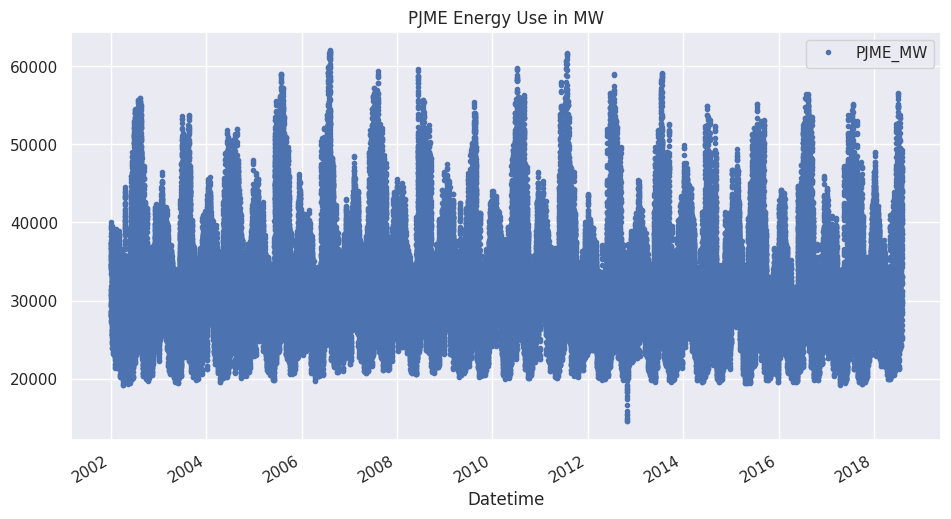

In [61]:
df.plot(style=".", 
        figsize=(10, 6),
        color=color_palette[0],
        title='PJME Energy Use in MW')
plt.show()

## Train/Test Split

In [62]:
train_df = df.loc[df.index < '01-01-2015']
test_df = df.loc[df.index >= '01-01-2015']

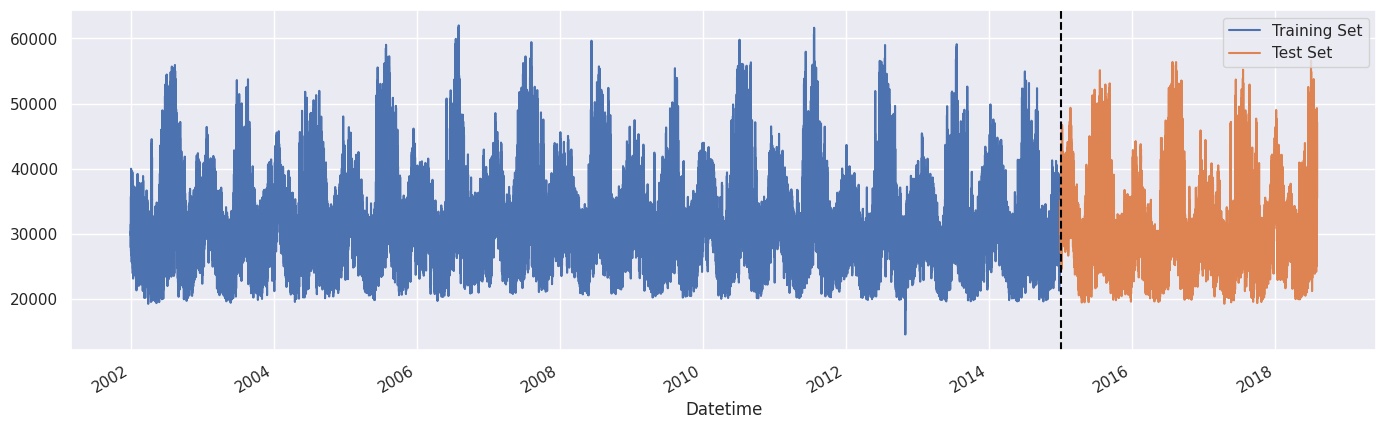

In [63]:
fig, ax = plt.subplots(figsize=(15, 5))
train_df.plot(ax=ax, label="Training Set")
test_df.plot(ax=ax, label="Test Set")
ax.axvline('01-01-2015', color='black', ls='--')
plt.legend(['Training Set', 'Test Set'])
plt.show()

<Axes: title={'center': 'Week of Data'}, xlabel='Datetime'>

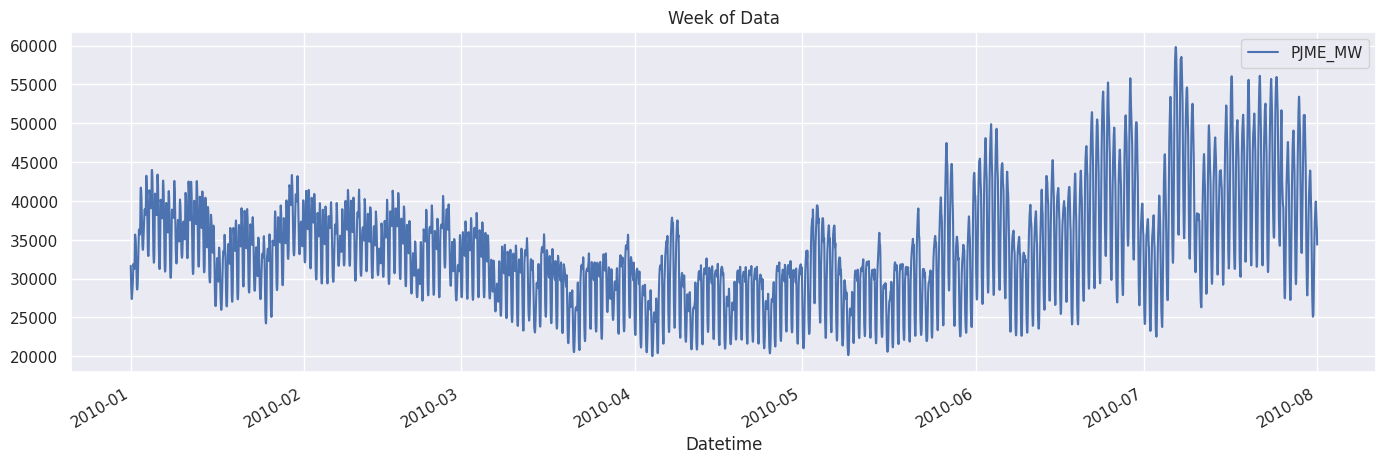

In [64]:
df.loc[(df.index >= '01-01-2010') & (df.index < '08-01-2010')] \
    .plot(figsize=(15, 5), title='Week of Data')

## Feature Creation

In [70]:
def extract_features(df: pd.DataFrame):
    """
    Create time series features based on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    
    return df

In [71]:
df = extract_features(df)
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


## Visualize feature/target relationship

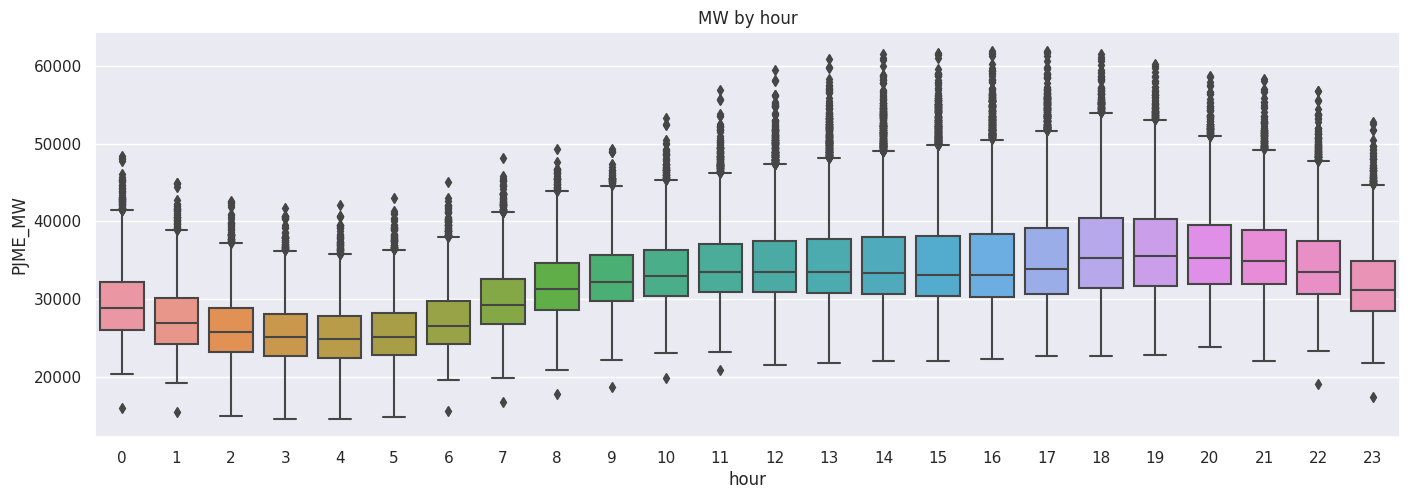

In [67]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df,
           x='hour',
           y='PJME_MW')
ax.set_title('MW by hour')
plt.show()

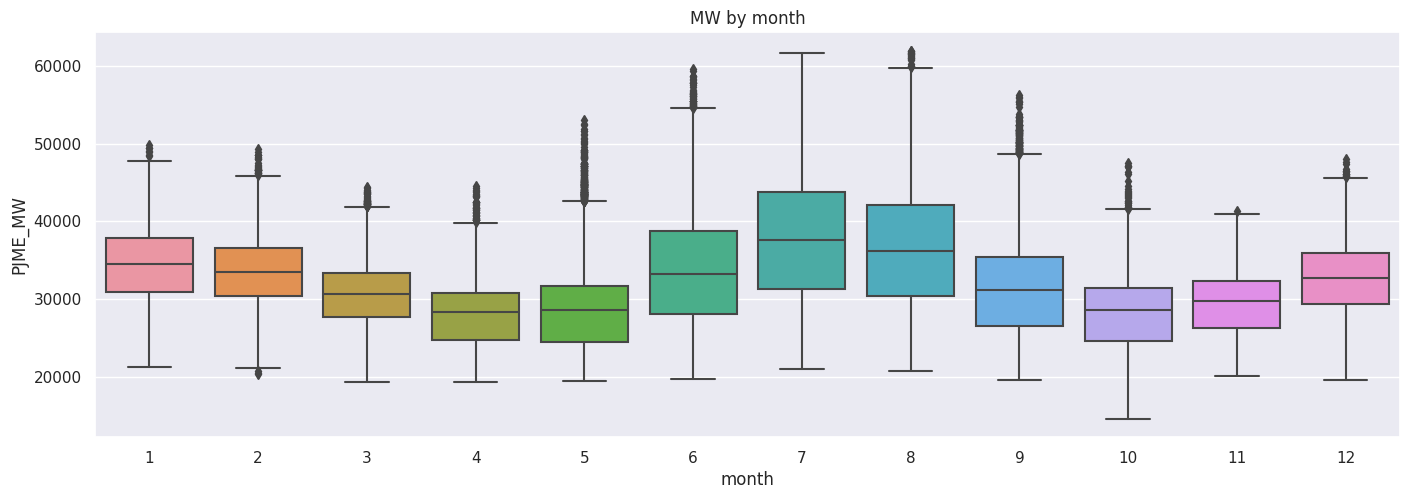

In [68]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=df,
           x='month',
           y='PJME_MW')
ax.set_title('MW by month')
plt.show()

## Create our model

In [72]:
train_df = extract_features(train_df)
test_df = extract_features(test_df)

In [73]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [74]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

In [86]:
X_train = train_df[FEATURES]
y_train = train_df[TARGET]

X_test = test_df[FEATURES]
y_test = test_df[TARGET]

In [88]:
reg = xgb.XGBRegressor(n_estimators=1000,
                      early_stopping_rounds=50)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True) 

[0]	validation_0-rmse:5179.23300	validation_1-rmse:5359.30943
[1]	validation_0-rmse:4375.01962	validation_1-rmse:4687.00132
[2]	validation_0-rmse:3874.17400	validation_1-rmse:4279.28898
[3]	validation_0-rmse:3572.89245	validation_1-rmse:4082.60841
[4]	validation_0-rmse:3372.17780	validation_1-rmse:3952.54672
[5]	validation_0-rmse:3247.62891	validation_1-rmse:3881.05746
[6]	validation_0-rmse:3162.64310	validation_1-rmse:3856.13245
[7]	validation_0-rmse:3073.82520	validation_1-rmse:3790.13994
[8]	validation_0-rmse:3021.60497	validation_1-rmse:3790.80157
[9]	validation_0-rmse:2967.30458	validation_1-rmse:3762.76936
[10]	validation_0-rmse:2888.42820	validation_1-rmse:3765.38080
[11]	validation_0-rmse:2870.15625	validation_1-rmse:3759.11653
[12]	validation_0-rmse:2813.33663	validation_1-rmse:3779.51021
[13]	validation_0-rmse:2779.04333	validation_1-rmse:3817.56184
[14]	validation_0-rmse:2760.93139	validation_1-rmse:3808.10832
[15]	validation_0-rmse:2739.22479	validation_1-rmse:3797.47445
[1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importances

In [90]:
reg.feature_importances_

array([0.4140169 , 0.08493857, 0.05416553, 0.26624683, 0.03595233,
       0.14467989], dtype=float32)

In [101]:
fi = pd.DataFrame(data=reg.feature_importances_,
            index=reg.feature_names_in_,
            columns=['importance']).sort_values(by='importance', ascending=False)
fi

,importance
hour,0.414017
month,0.266247
dayofyear,0.144680
dayofweek,0.084939
quarter,0.054166
year,0.035952


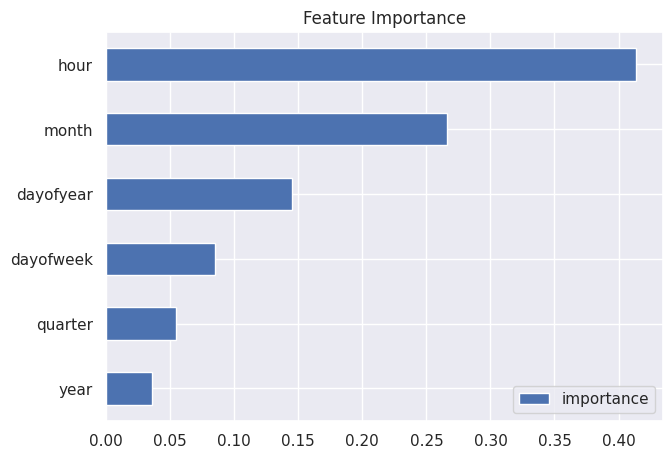

In [104]:
fi.sort_values(by='importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on Test Data

In [105]:
test_df['prediction'] = reg.predict(X_test)

In [106]:
test_df

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,32497.597656
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,28428.974609
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,27477.400391
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,27107.988281
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,27107.988281
...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,37893.890625
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,38392.046875
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,36828.960938


In [109]:
df = df.merge(test_df[['prediction']], how='left', left_index=True, right_index=True)

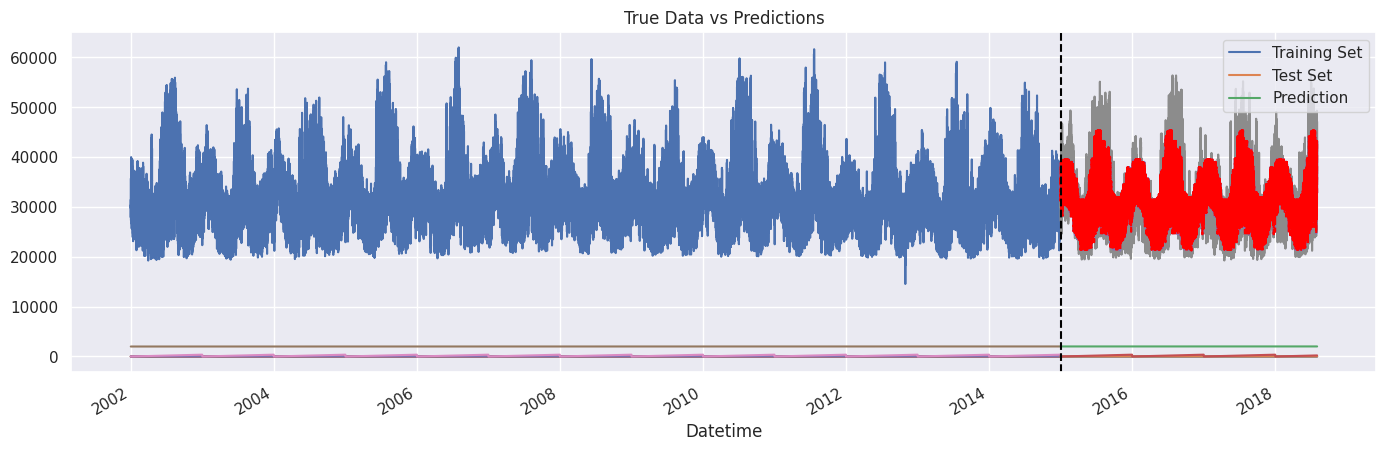

In [117]:
fig, ax = plt.subplots(figsize=(15, 5))
train_df.plot(ax=ax, label="Training Set")
test_df.plot(ax=ax, label="Test Set")
test_df['prediction'].plot(ax=ax, label="Prediction", linestyle='--', color='red')
ax.axvline('2015-01-01', color='black', ls='--')
ax.set_title('True Data vs Predictions')
plt.legend(["Training Set", "Test Set", "Prediction"])
plt.show()

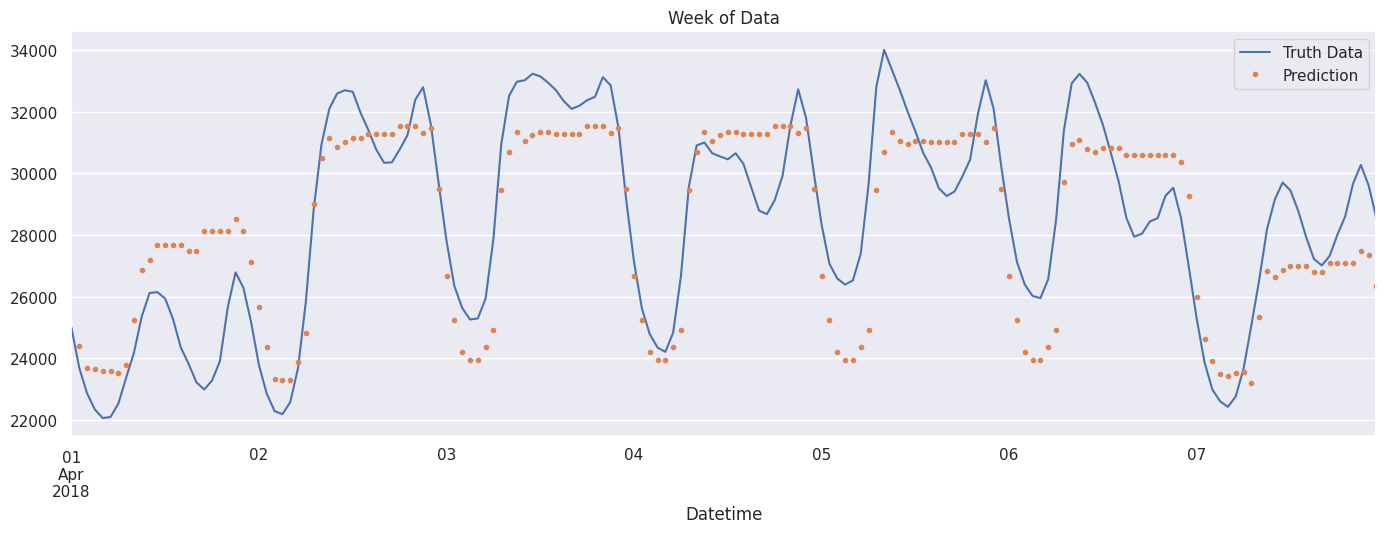

In [124]:
ax = df.loc[(df.index >= '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'].plot(figsize=(15, 5), title='Week of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'].plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [127]:
score = np.sqrt(mean_squared_error(test_df['PJME_MW'], test_df['prediction']))
print(f"RMSE Score on Test Set: {score}")

RMSE Score on Test Set: 3759.1165289523374


## Calculate Error

In [129]:
test_df['error'] = np.abs(test_df[TARGET] - test_df['prediction'])

In [130]:
test_df['date'] = test_df.index.date

In [136]:
# 5 worst predictions
test_df.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    14143.731527
2016-08-14    13856.622559
2016-09-10    11566.011149
2016-08-12    11432.267822
2016-09-09    10429.431315
Name: error, dtype: float64

In [137]:
# 5 best predictions
test_df.groupby('date')['error'].mean().sort_values().head(5)

date
2015-10-28    393.196777
2016-10-27    396.577962
2017-10-24    397.313151
2016-04-04    485.579671
2017-05-02    486.732096
Name: error, dtype: float64